In [56]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../') # path to bemcs

import bemcs
import bemcs.kernels_stress_displacement as kernels

def create_geometry(x1,x2,y1,y2):
    elements = []
    element = {}
    for i in range(len(x1)):
        element["x1"] = x1[i]
        element["y1"] = y1[i]
        element["x2"] = x2[i]
        element["y2"] = y2[i]
        elements.append(element.copy())
    elements = bemcs.standardize_elements(elements)
    return elements

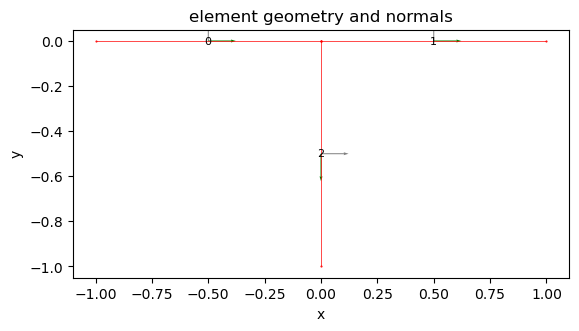

In [57]:
# Elastic parameters
mu = 1
nu = 0.25

x1 = np.array((-1.,0,0))
x2 = np.array((0.,1.,0.))
y1 = np.array((0.,0.,0.))
y2 = np.array((0.,0.,-1.0))

elements = create_geometry(x1,x2,y1,y2)
n_elements = len(elements)

# slip vector
slip_vector_x = np.array((1.0,0.5,-0.5))
slip_vector_y = np.array((0.,0.5,-0.5))

plt.figure()
bemcs.plot_element_geometry(elements)
plt.show()

In [58]:
# observation point
n_obs = 200
width = 2
x_obs = np.linspace(-width, width, n_obs)
y_obs = np.linspace(-width/2, width/2, n_obs)

x_obs, y_obs = np.meshgrid(x_obs, y_obs)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

# compute shear and tensile stress kernels
# kernels are [Kxx,Kyy,Kxy,Gx,Gy] x [Nobs x Ncoefficients]
# the last argument passed is a flag for shear/tensile source (1 - shear, 0 - tensile)
kernels_s = kernels.get_quadratic_displacement_stress_kernel(x_obs,y_obs,elements,mu,nu,1)
kernels_n = kernels.get_quadratic_displacement_stress_kernel(x_obs,y_obs,elements,mu,nu,0)

/Users/mallickrishg/Dropbox/scripts/Pythoncode/bemcs/examples/../bemcs/bemcs.py:403: RuntimeWarning: divide by zero encountered in divide
  arctan_x_minus_a = np.pi / 2 * np.sign(y / (a - x)) - np.arctan(y / (a - x))


### Boundary Conditions and Design Matrix

The number of equations for a given system with $N$ fault elements can be calculated as follows:
1. $2N$ equations for the central node of every element
2. $2N_o$ equations at the open nodes, where $N_o$ is the number of nodes that belong to only 1 fault element
3. $4N - 2N_o - 2N_t$ equations applied at interior nodes, where an interior node is any node that is shared by more than 1 fault element. $N_t$ is the number of triple junctions.

There are $6N$ unknown $3qn$ coefficients we need to solve for. Below we discuss the shape of the design matrix for a few typical cases:
- When the domain is a simply connected closed loop, there are no open nodes and no triple junctions, we have
  - $2N$ equations for the central node, $4N$ equations at the interior nodes
- When the domain is an open loop, there are $2$ open nodes at the ends of the mesh and we have
  - $2N$ equations for the central node, $4N-4$ equations at the interior nodes, $4$ equations at the open nodes
- For the case considered in this example, we have $N=3$ elements with $3$ open nodes and $1$ triple junction, and no other interior nodes. The equations in this case are not equal to the number of unknowns
  - $6$ equations for the central node, $6$ equations at the open nodes and $4$ equations at the triple junction. This gives a total of $16$ equations while there are $18$ unknowns.

## Issue
- When I run a case where 1 of the fault elements is set to 0 slip, I expect to recover the limiting case of two fault elements - as if the third fault element does not exist. However, I end up with non-zero slip on the element that should have 0 slip. This implies that there are 2 other equations we need - what are they???

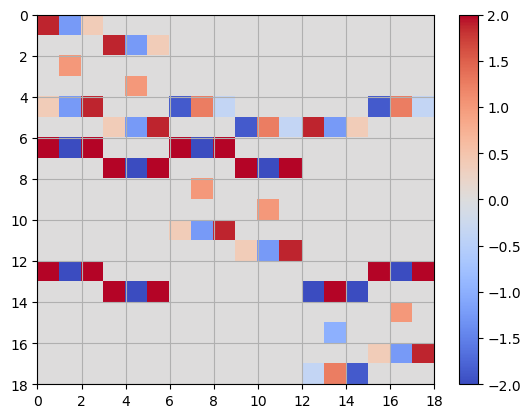

In [59]:
# design matrices (in x,y coordinates) for slip and slip gradients at each 3qn
matrix_slip,matrix_slipgradient = kernels.get_designmatrix_xy_3qn(elements,flag="node")
matrix_slip_mean,_ = kernels.get_designmatrix_xy_3qn(elements,flag="mean")

# N_c = 2*len(elements)
# N_o = 2*3 # open nodes
# N_t = 2*1 # triple junctions
# N_i = 4*len(elements) - N_o - N_t
# Nequations = N_c + N_o + N_i

Nequations = len(elements)*6 
Nunknowns = len(elements)*6

# normally this matrix is square but for a 3 fault segment intersections/triple junction it ends up 
# Nequations = Nunknowns - 2*(number_triplejunctions)
matrix_system = np.zeros((Nequations,Nunknowns))

# We will stack this with 
# 2N equations for the element centers
# 2*(number_opennodes) equations at open nodes
# 4N - 2*(number_triplejunctions) - 2*(number_opennodes) equations for continuity and smoothness at interior nodes
BCvector = np.zeros((Nequations,1))

# slip boundary condition for element centers
# BCvector[0:N_c:2] = slip_vector_x.reshape((-1,1))
# BCvector[1:N_c:2] = slip_vector_y.reshape((-1,1))

# slip BCs for open nodes
# BCvector[N_c:N_c+N_o] = 0.

BCvector[2::6] = slip_vector_x.reshape((-1,1))
BCvector[3::6] = slip_vector_y.reshape((-1,1))

# Linear operator for BCs as a matrix
# boundary nodes (set to 0 slip)
matrix_system[0:2,:] = matrix_slip[0:2:] # first element open node
matrix_system[10:12,:] = matrix_slip[10:12:] # second element open node
matrix_system[16:18,:] = matrix_slip[16:18,:] # last element open node

# patch center nodes (for x,y components)
matrix_system[2::6,:] = matrix_slip[2::6,:] # x component
matrix_system[3::6,:] = matrix_slip[3::6,:] # y component

# overlapping interior nodes (apply slip continuity and smoothness)
# continuity
# triple junction equation
matrix_system[4,:] = matrix_slip[4,:] - matrix_slip[6,:] - matrix_slip[12,:]# x component
matrix_system[5,:] = matrix_slip[5,:] - matrix_slip[7,:] - matrix_slip[13,:]# y component
# regular continuity equations (this produces singularities)
# matrix_system[4,:] = matrix_slip[4,:] - matrix_slip[6,:] # x component
# matrix_system[5,:] = matrix_slip[5,:] - matrix_slip[7,:] # y component
# matrix_system[12,:] = matrix_slip[4,:] - matrix_slip[12,:] # x component
# matrix_system[13,:] = matrix_slip[5,:] - matrix_slip[13,:] # y component

# smoothness
# triple junction
# matrix_system[6,:] = matrix_slipgradient[4,:] - matrix_slipgradient[6,:] - matrix_slipgradient[12,:]# x component
# matrix_system[7,:] = matrix_slipgradient[5,:] - matrix_slipgradient[7,:] - matrix_slipgradient[13,:]# y component
# regular smoothness
matrix_system[6,:] = matrix_slipgradient[4,:] - matrix_slipgradient[6,:]
matrix_system[7,:] = matrix_slipgradient[5,:] - matrix_slipgradient[7,:]
matrix_system[12,:] = matrix_slipgradient[4,:] - matrix_slipgradient[12,:]
matrix_system[13,:] = matrix_slipgradient[5,:] - matrix_slipgradient[13,:]

# plot design matrix
_,ax = plt.subplots()
pc = ax.pcolor(matrix_system,cmap="coolwarm",shading='flat')
ax.grid(which='both')
ax.invert_yaxis()
pc.set_clim(-2,2)
plt.colorbar(pc)
plt.show()


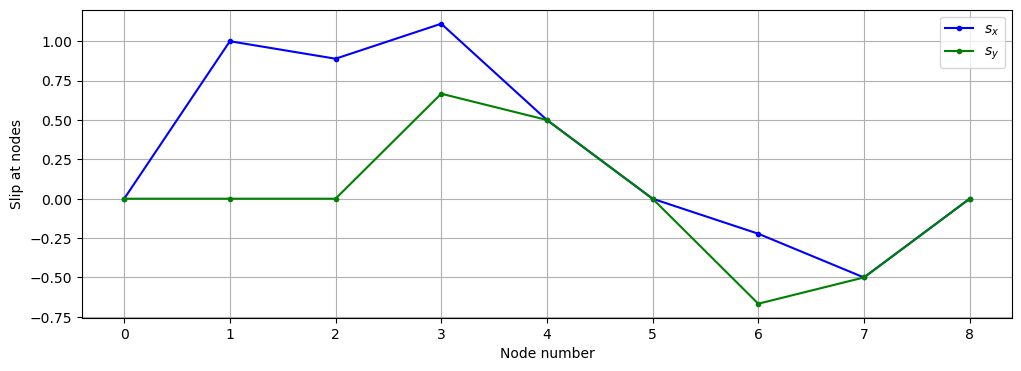

[[ 8.88888889e-01  3.26336134e-16]
 [ 1.11111111e+00  6.66666667e-01]
 [-2.22222222e-01 -6.66666667e-01]]


In [60]:
# compute quadratic node coefficients (in local (s,n) coordinates)
quadratic_coefs = np.linalg.pinv(matrix_system) @ BCvector
# quadratic_coefs = np.linalg.lstsq(matrix_system,BCvector)[0]

# print(matrix_system@quadratic_coefs - BCvector)

# extract (s,n) components and store them in 2 separate vectors
quadratic_coefs_s = np.zeros((len(elements)*3,1))
quadratic_coefs_n = np.zeros((len(elements)*3,1))
for i in range(len(elements)):
    quadratic_coefs_s[3*i:3*(i+1)] = quadratic_coefs[6*i:6*i+3]
    quadratic_coefs_n[3*i:3*(i+1)] = quadratic_coefs[6*i+3:6*(i+1)]

# extract slip at nodes from quadratic coefficients
slip_nodes = matrix_slip @ quadratic_coefs
slip_nodes_x = slip_nodes[0::2]
slip_nodes_y = slip_nodes[1::2]
slip_vector = np.hstack((slip_nodes_x,slip_nodes_y))
# rotate from (x,y) to (s,n) for slip vector
slip_nodes_s = np.zeros((3*len(elements),1))
slip_nodes_n = np.zeros((3*len(elements),1))

for i in range(len(elements)):
    dummy = slip_vector[3*i:3*(i+1),:]@elements[i]["rotation_matrix"]
    slip_nodes_s[3*i:3*(i+1),0] = dummy[:,0]
    slip_nodes_n[3*i:3*(i+1),0] = dummy[:,1]

xnodes = np.zeros((3*len(elements),1))
xnodes[0::3,0] = x1
xnodes[2::3,0] = x2
xnodes[1::3,0] = 0.5*(x1 + x2)

plt.figure(figsize=(12,4))
plt.plot(slip_nodes_x,'b.-',label='$s_x$')
plt.plot(slip_nodes_y,'g.-',label='$s_y$')
plt.xlabel("Node number")
plt.ylabel("Slip at nodes")
plt.legend()
plt.grid()
plt.show()

print(np.hstack((slip_nodes_x[[2,3,6]],slip_nodes_y[[2,3,6]])))


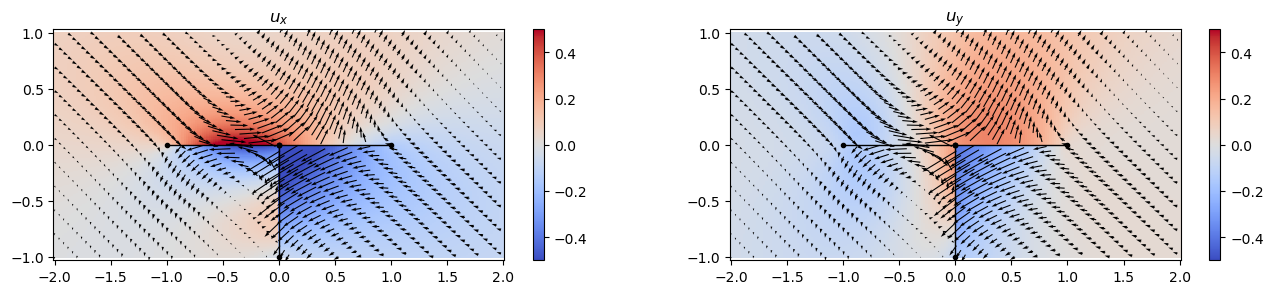

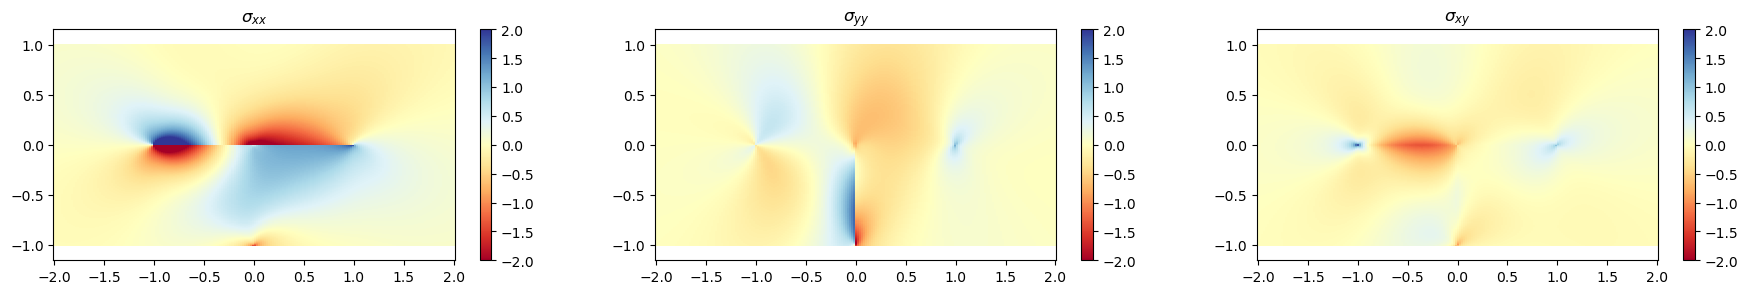

In [61]:
# kernels_s[6]
# compute displacement and stresses (we will plot it later)
ux = kernels_s[3] @ (quadratic_coefs_s) + kernels_n[3] @ quadratic_coefs_n
uy = kernels_s[4] @ (quadratic_coefs_s) + kernels_n[4] @ quadratic_coefs_n
sxx = kernels_s[0] @ (quadratic_coefs_s) + kernels_n[0] @ quadratic_coefs_n
syy = kernels_s[1] @ quadratic_coefs_s + kernels_n[1] @ quadratic_coefs_n
sxy = kernels_s[2] @ quadratic_coefs_s + kernels_n[2] @ quadratic_coefs_n

nskip_plot = 42 # plotting for vectors

# displacements
plt.figure(figsize=(16,3))
plt.subplot(1, 2, 1)
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), ux.reshape(n_obs, n_obs),cmap='coolwarm')
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.clim(-0.5,0.5)
plt.colorbar()
plt.quiver(x_obs[0::nskip_plot],y_obs[0::nskip_plot],ux[0::nskip_plot],uy[0::nskip_plot])
plt.axis("equal")
plt.title("$u_x$")

plt.subplot(1, 2, 2)
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), uy.reshape(n_obs, n_obs),cmap='coolwarm')
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.clim(-0.5,0.5)
plt.colorbar()
plt.quiver(x_obs[0::nskip_plot],y_obs[0::nskip_plot],ux[0::nskip_plot],uy[0::nskip_plot])
plt.title("$u_y$")
plt.axis("equal")
plt.show()

# plot stresses
plt.figure(figsize=(22, 3))
plt.subplot(1, 3, 1)
toplot = sxx
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),cmap='RdYlBu',vmin=-1.5,vmax=1.5)
# for element in elements:
    # plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.colorbar()
plt.clim(-2,2)
plt.axis("equal")
plt.title("$\sigma_{xx}$")

plt.subplot(1, 3, 2)
toplot = syy
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),cmap='RdYlBu',vmin=-1.5,vmax=1.5)
# for element in elements:
    # plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.colorbar()
plt.clim(-2,2)
plt.axis("equal")
plt.title("$\sigma_{yy}$")

plt.subplot(1, 3, 3)
toplot = sxy
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),cmap='RdYlBu',vmin=-1.5,vmax=1.5)
# for element in elements:
#     plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.colorbar()
plt.clim(-2,2)
plt.axis("equal")
plt.title("$\sigma_{xy}$")
plt.show()
